#### THIS PROGRAM LOADS UP THE H SURFACE DATA (generated with Hasigma5.f) AND PLOTS IT.
#### It can alse be used to compare the model with numerical integrations of the exact equations of motion.

In [1]:
# Libraries used:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import scipy as sc
import os
import sys
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv # https://ipyvolume.readthedocs.io/en/latest/install.html
from ipywidgets import VBox
from matplotlib import cm
from matplotlib import ticker 
import rebound
from IPython.display import display, clear_output
from ipywidgets import IntProgress
from IPython.display import display
import time

# Some general setup for plots:
#mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 17
mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

# Real cases:
# HD31527/cd   AM=0.8795   16:3  -> Buen ejemplo al borde de un ACR.
# GJ876/bc     AM=0.9929    2:1  -> Parece estar en el centro de un ACR muy chiquito al borde de la sup. H.
# GJ876/ce     AM=0.9995    2:1  -> Sup. H muy chica.
# HD73526/bc   AM=0.9587    2:1  -> Ej. perfecto de deep MMR.
# HD181433/cd  AM=0.9156    7:1  -> Esta en reso unos 60 kyrs, luego se sale.
# K278/bc      AM=0.7474    5:3  -> No esta en esta MMR. Hay encuentro.
# K278/bc      AM=0.7475   12:7  -> No esta en esta MMR. Hay encuentro luego de mucho tiempo.
# K278/bc      AM=0.7475   17:10 -> No esta en esta MMR. Hay encuentro.
# GJ3512/bc    AM=0.9454    8:1  -> No esta en MMR. Hay evo secular pura estable.
# HIP57050/bc  AM=0.9342   13:1  -> (~GJ1148) No esta en MMR. Hay evo secular pura estable.
# NNSer/cd     AM=0.       15:7  -> (~GJ1148)
# HD147873/bc  AM=0.9762   17:4  -> No esta en MMR. Hay evo secular pura estable.
# HD128311/bc  AM=0.9806    2:1  -> Ejemplo similar al HD73526/bc pero con amplitud no nula de libración.
# HD183263/bc  AM=0.9837   15:2  -> Dio como 30 sigmas, hay un mucho ruido en la sup H en esa zona :(
# K2-146/bc    AM=0.9884    3:2  -> Esta en MMR y ademas muy cerca de un ACR.
# K2-19/bc     AM=0.9792    3:2  -> Esta en MMR y es un ejemplo de un ACR con centro de lib circulando.

In [2]:
# IMPORTANT PARAMETER DEFINITIONS:

# K2:K1 resonance?
K2 = 1
K1 = 1
RESO = str(K2) + '-' + str(K1) # String "K2-K1"

# Planet to study? (1 or 2 <---> int or ext)
PLA = '2'

# Study particular case?
PARTICULAR = False

# DATA FOR GENERAL CASE (Ignore if PARTICULAR = True):
# Mass and/or e1,e2 case?
#CASO = "/m12=20/e12=.4.4/"
M21_str = "1.00" #"m21=20.00"
M21 = float(M21_str)
if M21>=1:
    M21 = int(M21)
# Normalized angular momentum (between 0 and 1 with 4 decimals)
AM_str = "0.90"
AM = float(AM_str)
AM_norm = AM
# Summarize case in CASO
CASO = RESO + "/m21=" + str(M21) + "/AM=" + AM_str + "/"
if (not PARTICULAR):
    print('H surface case: ',CASO)


# DIRECTORIES and FILES:
# Common directory root (in Windows use inverted double slash "\\"; in Linux use single slash "/"):
COMUN = "/home/juan/Escritorio/TESIS/"

# H surface data directory:
dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + CASO

# Filename:
file_H = "HSUP" + PLA + "_MMR" + RESO + "_m21=" + M21_str + "_AM=" + AM_str + ".dat" #"HSUP1_MMR2-1_m21=1.00_AM=0.80.dat"

# plares input filename:
file_in = 'plares_clusteruy.inp'

sistema = "K2-146/bc"
AM_par  = "0.9884"
if (PARTICULAR):
    dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/PARTICULARES/" + sistema + "/" #+ RESO + "/"
    file_H = "HSUP" + PLA + "_middle_RHtol=0.00_AM=" + AM_par + ".dat"
    file_in = 'plares.inp'

int_setup = "ints/"
# Graphics directory to save H surface plots:
#dir_graf = "/home/juan/Escritorio/"
#dir_graf = COMUN + "DOC/Planetario/" + CASO
dir_graf = dir_H + int_setup
# Surface plots filenames:
fileH_graf = "HSUP" 
fileMD_graf = "MDSUP"

# Numerical integration comparisons directories:
dirs_int = ['e2=0.59_dw=180_s1=0',
            'e2=0.52_dw=180_s1=0',
            'e2=0.44_dw=180_s1=0',
            'e2=0.59_dw=-99_s1=110',
            'e2=0.55_dw=-99_s1=121',
            'e2=0.49_dw=-99_s1=126',
            'e2=0.44_dw=-99_s1=127',
            'e2=0.47_dw=60_s1=61',
            'e2=0.44_dw=60_s1=60',
] 

if PARTICULAR: dirs_int = ['e1=0.14_w1=189_s1=7'] # particular single case

dirs_int = [dir_H + int_setup + caso + "/" for caso in dirs_int] # prepend dir_H

file_data_pla1 = "planet1.dat"
file_data_pla2 = "planet2.dat"


# ***** BOOLEAN FLAGS ***** (...for some setup...):
# General setup:
# If ANGLE = 0 => The angles: (0, 360). If ANGLE = 1 => The angles: (-180,180). 
ANGLE = 1
# Save plots? (only num int data and normal plots, interactive ones are saved using the widget menu)
GUARDAR = False

# H surface setup:
# Use theta instead of sigma? 
THETA = False
# Plot mindis surface?
MINDIS = True
# Filter according RHtol? (encounter if mindis<RHtol)
RHtol = 3 #2*sqrt(3)
# Interpolate H surface to increase precision?
INTERPOLAR = True
# By default H surface are in black and white, do you want color?
COLOR = False
# Project H surface on plane (e1,dw)?
PROYECTAR = True

# Numerical integration setup:
# Compare with numerical integration loaded from an input file?
COMPARAR = True
# Intregate in this notebook using Rebound?
INTEGRAR = False
# Some aspects of integrations:
# 1) If COMPARE = True, then numerical integrations are uploaded from dirs_int locations
# 2) If INTEGRAR = True, the integration initial conditions are defined depending on the ACR encountered
# in cell 11. See cell 10 for more information.
# 3) All integrations ran with Rebound are saved in dir_H by default. 
# 4) See cells 12 and 13 for numerical integration setup.
# The precision of the integration uploaded when COMPARAR = True can be lowered.
FIL = 1   # FIL is the factor by the precision is lowered. FIL = 1 does not skip any data.
proy = 1   # If want a projection in the interactive plots, set proy = 0, if not, set proy = 1.
fac = 1.0 # Factor that mulitplies a1i (to find a better a1i in case structure law bothers).

# Plots setup:
# Image quality? (in dpi, 150 is ok)
cal = 150
# Format? ('png', 'jpeg', 'eps', etc)
formato = 'jpeg'
# Surface plots file names:
fileH_graf  = fileH_graf  + "." + formato
fileMD_graf = fileMD_graf + "." + formato


# *** ATENTION USER: ***
#
# From here on, what ever modification is made to the script, is at your own risk *¬* 
#                                                                                  O

H surface case:  1-1/m21=1/AM=0.90/


In [3]:
# Obtain planetary system information and calculate AM or eta

file = open(dir_H + file_in, "r", encoding = "ISO-8859-1")

if (PARTICULAR):
    string1 = 'STAR: mass of the star in solar masses'
    string2 = 'PLANETS: a(au) e i lonod  loper  mass (in solar masses)'
else:
    string1 = 'Mass of the star in solar masses:'
    string2 = 'Mass of the planet 1 (interior):'
    string3 = 'Mass of the planet 2 (exterior):'
    string4 = 'Planet 2 semi-major axis (in au):'
    
# setting flag to 0
flag = 0

# Loop through the file line by line

if (PARTICULAR):

    for line in file:
   
        if (flag == 1):
            m0 = float(line) # Masa de la estrella
            flag = 0
        if (flag == 2):
            pla1 = line # Info planeta 1
            elem1 = pla1.split()
            flag = 3
        if (flag == 4):
            pla2 = line # Info planeta 2
            elem2 = pla2.split()
            flag = 0
        if (flag == 3):
            flag = 4

        # checking string is present in line or not
        if string1 in line:
            flag = 1
        if string2 in line:
            flag = 2

    #print(m0, elem1, elem2)

    a1i = float(elem1[0])
    e1i = float(elem1[1])
    i1i = float(elem1[2])
    O1i = float(elem1[3])
    w1i = float(elem1[4])
    m1  = float(elem1[5])
    
    a2i = float(elem2[0])
    e2i = float(elem2[1])
    i2i = float(elem2[2])
    O2i = float(elem2[3])
    w2i = float(elem2[4])
    m2  = float(elem2[5])

    
# GENERAL CASE
else:
    
    for line in file:
    
        if (flag == 1):
            m0 = float(line) # star mass
            flag = 0
        if (flag == 2):
            m1 = float(line) # planet 1 mass
            flag = 0
        if (flag == 3):
            m2 = float(line) # planet 2 mass
            flag = 0
        if (flag == 4):
            a2i = float(line) # planet 2 semi-major axis
            flag = 0

        # checking string is present in line or not
        if string1 in line:
            flag = 1
        if string2 in line:
            flag = 2
        if string3 in line:
            flag = 3
        if string4 in line:
            flag = 4
        
    a1i = fac*a2i*(((K1/K2)**2)*((m0+m1)/(m0+m2)))**(1/3) # in the general case, we assume planets in deep MMR

# closing plares.inp
file.close()

# AM/eta calculation:
G = 0.01720209895**2
mu1 = G*(m1 + m0)*a1i
mu2 = G*(m2 + m0)*a2i
beta1 = m1*m0/(m1 + m0)
beta2 = m2*m0/(m2 + m0)
C1 = beta1*sqrt(mu1)
C2 = beta2*sqrt(mu2)
if (PARTICULAR):
    AM_min = 0
    AM_max = C1 + C2
    AM_norm = AM
    AM = AM_norm*AM_max  
eta = C2/C1

print('(m0,m1,m2,a1,a2) = (',m0,',',m1,',',m2,',',a1i,',',a2i,')')
if PARTICULAR:
    print('AM =', AM)
    print('AMnorm =', AM_norm)
print('m2/m1 =',m2/m1)
print('eta =',eta)
print('approximate eta =',(m2/m1)*(K2/K1)**(1/3))

(m0,m1,m2,a1,a2) = ( 1.0 , 0.001 , 0.001 , 1.0 , 1.0 )
m2/m1 = 1.0
eta = 1.0
approximate eta = 1.0


In [4]:
# LOAD H SURFACE DATA:
Din_Hsup = pd.read_csv(dir_H + file_H, delimiter=r"\s+")
# Some times e=1 noise needs to be filtered (if not, comment next line)
Din_Hsup = Din_Hsup[Din_Hsup['e' + PLA].values < 0.99]

# Din_Hsup = Din_pro

H = Din_Hsup['R'].values

# Remove outliers (https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python) 
z_scores = sc.stats.zscore(H)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
Din_Hsup = Din_Hsup[filtered_entries]      

if (MINDIS):    
    Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
    MD_sup = Din_Hsup['mindis'].values
    
# Obtain variables from dataframe:
E_sup = Din_Hsup['e' + PLA].values
W_sup = Din_Hsup['deltavarpi'].values % 360
H_sup = -Din_Hsup['R'].values
S_sup = Din_Hsup['sigma1'].values % 360

res_angle = "σ"
if (THETA):
    S_sup = (S_sup - (K2-K1)*W_sup) % 360
    res_angle = "θ"
    
if (ANGLE == 1):
    W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
    S_sup = np.where(S_sup>180, S_sup - 360, S_sup)
    
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(Din_Hsup)

In [5]:
# Interpolate data to increase precision

e_arr = np.unique(E_sup)
w_arr = np.unique(W_sup)

if INTERPOLAR:
    
    # FUNCIÓN PARA OBTENER EL ANGULO MAS CERCANO DE UN ARRAY DE ANGULOS:
    def find_nearest_ang(ang_arr, ang):
        G2R = pi/180  
        ind = 0
        angulo = ang_arr[ind]
        X = sin(ang*G2R)
        Y = cos(ang*G2R)
        deltamin = 2    
        for i in range(len(ang_arr)):    
            angi = ang_arr[i]    
            x = sin(angi*G2R)
            y = cos(angi*G2R)    
            delta = (x-X)**2 + (y-Y)**2   
            if (delta < deltamin):
                deltamin = delta
                ind = i
                angulo = angi   
        return ind
        #return angulo, ind

    def avg_ang(a, b): # https://en.wikipedia.org/wiki/Circular_mean
        G2R = pi/180  
        ax = sin(a*G2R)
        bx = sin(b*G2R)
        ay = cos(a*G2R)
        by = cos(b*G2R)
        avg = (atan2((ax+bx)/2,(ay+by)/2))/G2R
        return avg
    
    
    # PREPARO LOOP
#     e_arr = np.unique(E_sup)
#     w_arr = np.unique(W_sup)

    de = abs(e_arr[2] - e_arr[1])
    dw = abs(w_arr[2] - w_arr[1])

    Dnews = pd.DataFrame(columns = ['e'+PLA, 'deltavarpi', 'sigma1', 'R', 'mindis'])

    # LOOP:
    for e in e_arr:
        for w in w_arr:

    # PUNTO ACTUAL
            Dsig = Din_Hsup[ (E_sup == e) & (W_sup == w) ]
            sigmas = Dsig['sigma1'].values # % 360
            Hs = Dsig['R'].values
            minds = Dsig['mindis'].values
            # cantidad de sigmas:
            Nsig = len(sigmas)

    # HAY 3 INSTANCIAS DE INTERPOLACION POR PUNTO, HACIA X=e, HACIA Y=w Y HACIA AMBAS DIRECCIONES.

            DsigX = Din_Hsup[ (E_sup == round(e + de, 3)) & (W_sup == round(w, 1)) ]
            if not DsigX.empty: 
                sigmasX = DsigX['sigma1'].values % 360
                HsX = DsigX['R'].values
                mindsX = DsigX['mindis'].values
                # cantidad de sigmas:
                NsigX = len(sigmasX)

                if (NsigX == Nsig):

                    for i in range(Nsig):

                        # punto actual
                        sigma = sigmas[i]
                        H     = Hs[i]
                        mind  = minds[i]

                        # punto siguiente
                        if (Nsig>1):
                            ind = find_nearest_ang(sigmasX, sigma)
                        else:
                            ind = i
                        sigmaX = sigmasX[ind]
                        HX = HsX[ind]
                        mindX = mindsX[ind]
                            
                        # punto nuevo
                        #sigma_new = ((sigma + sigmaX)/2) % 360
                        sigma_new = avg_ang(sigma,sigmaX)
                        if (ANGLE == 1):
                            sigma_new = np.where(sigma_new>180, sigma_new - 360, sigma_new)
                        H_new = (H+HX)/2
                        mind_new = (mind+mindX)/2

#                        punto_new = [e + de/2, w, sigma_new, H_new, mind_new]
                        punto_new = [round(e + de/2, 3), round(w, 1), np.round(sigma_new, 1), H_new, mind_new]
                        Dnews.loc[len(Dnews)] = punto_new
        


            DsigY = Din_Hsup[ (E_sup == round(e, 3)) & (W_sup == round(w + dw, 1)) ]   
            if not DsigY.empty: 
                sigmasY = DsigY['sigma1'].values % 360
                HsY = DsigY['R'].values
                mindsY = DsigY['mindis'].values
                # cantidad de sigmas:
                NsigY = len(sigmasY)

                if (NsigY == Nsig):

                    for i in range(Nsig):

                        # punto actual
                        sigma = sigmas[i]
                        H     = Hs[i]
                        mind  = minds[i]

                        # punto siguiente
                        if (Nsig>1):
                            ind = find_nearest_ang(sigmasY, sigma)
                        else:
                            ind = i
                        ind = find_nearest_ang(sigmasY, sigma)
                        sigmaY = sigmasY[ind]
                        HY = HsY[ind]
                        mindY = mindsY[ind]

                        # punto nuevo
                        #sigma_new = ((sigma + sigmaY)/2) % 360
                        sigma_new = avg_ang(sigma,sigmaY)
                        if (ANGLE == 1):
                            sigma_new = np.where(sigma_new>180, sigma_new - 360, sigma_new)
                        H_new = (H+HY)/2
                        mind_new = (mind+mindY)/2

#                         punto_new = [e, w + dw/2, sigma_new, H_new, mind_new]
                        punto_new = [round(e, 3), round(w + dw/2, 1), np.round(sigma_new, 1), H_new, mind_new]
                        Dnews.loc[len(Dnews)] = punto_new


            DsigXY = Din_Hsup[ (E_sup == round(e + de, 3)) & (W_sup == round(w + dw, 1)) ]
            if not DsigXY.empty:     
                sigmasXY = DsigXY['sigma1'].values % 360
                HsXY = DsigXY['R'].values
                mindsXY = DsigXY['mindis'].values
                # cantidad de sigmas:
                NsigXY = len(sigmasXY)

                if (NsigXY == Nsig):

                    for i in range(Nsig):

                        # punto actual
                        sigma = sigmas[i]
                        H     = Hs[i]
                        mind  = minds[i]

                        # punto siguiente
                        if (Nsig>1):
                            ind = find_nearest_ang(sigmasXY, sigma)
                        else:
                            ind = i
                        ind = find_nearest_ang(sigmasXY, sigma)
                        sigmaXY = sigmasXY[ind]
                        HXY = HsXY[ind]
                        mindXY = mindsXY[ind]

                        # punto nuevo
                        #sigma_new = ((sigma + sigmaXY)/2) % 360
                        sigma_new = avg_ang(sigma,sigmaXY)
                        if (ANGLE == 1):
                            sigma_new = np.where(sigma_new>180, sigma_new - 360, sigma_new)
                        H_new = (H+HXY)/2
                        mind_new = (mind+mindXY)/2

#                         punto_new = [e + de/2, w + dw/2, sigma_new, H_new, mind_new]
                        punto_new = [round(e + de/2, 3), round(w + dw/2, 1), np.round(sigma_new, 1), H_new, mind_new]
                        Dnews.loc[len(Dnews)] = punto_new

    # Join both dataframes into one:
    Din_Hsup = pd.concat([Din_Hsup, Dnews], ignore_index=True)

    # RE-ASSIGN VARIABLES AFTER INTERPOLATING:    
    
#     # Remove outliers (https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python) 
#     H = Din_Hsup['R'].values
#     z_scores = sc.stats.zscore(H)
#     abs_z_scores = np.abs(z_scores)
#     filtered_entries = (abs_z_scores < 3) # 3-1 -> 1.5
#     Din_Hsup = Din_Hsup[filtered_entries]  
    
    if (MINDIS):    
#         Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
        MD_sup = Din_Hsup['mindis'].values

    # Obtain variables from dataframe:
    E_sup = Din_Hsup['e' + PLA].values
    W_sup = Din_Hsup['deltavarpi'].values % 360
    H_sup = -Din_Hsup['R'].values
    S_sup = Din_Hsup['sigma1'].values % 360

    if (THETA):
        S_sup = (S_sup - (K2-K1)*W_sup) % 360

    if (ANGLE == 1):
        W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
        S_sup = np.where(S_sup>180, S_sup - 360, S_sup)

#     E_sup = np.array(E_sup, dtype=float)
#     W_sup = np.array(W_sup, dtype=float)
#     S_sup = np.array(S_sup, dtype=float)
#     H_sup = np.array(H_sup, dtype=float)
#     MD_sup = np.array(MD_sup, dtype=float)

# Printing stuff for debugging

#np.set_printoptions(threshold=sys.maxsize)

# print(e_arr)
# print(w_arr)

# print(E_sup)
# print(W_sup)
# print(S_sup)
# print(H_sup)
# print(MD_sup)

# if(np.isnan(S_sup).any()):
#     print("The Array contain NaN values")
# else:
#     print("The Array does not contain NaN values")
    
# print(np.min(H_sup), np.max(H_sup))
  
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(Dnews)    
    
# with pd.option_context('display.max_rows', None,
#                            'display.max_columns', None,
#                            'display.precision', 3,
#                            ):
#     print(Din_Hsup)

In [6]:
# Load numerical integration from files

if (COMPARAR):
   
    Nints = len(dirs_int)
    t1    = []
    a1int = []
    e1int = []
    w1int = []
    l1int = []
    t2    = []
    a2int = []
    e2int = []
    w2int = []
    l2int = []
    s1int = []
    deltawint = []
    
    for i in range(Nints):
    
        dir_int = dirs_int[i]

        # 2 dataframes, one for planets, another for particles
        Dpla1 = pd.read_csv(dir_int + file_data_pla1, delimiter=r"\s+")
        Dpla2 = pd.read_csv(dir_int + file_data_pla2, delimiter=r"\s+")

        # filter some data
        Dpla1 = Dpla1[Dpla1.index.map(lambda x: x%FIL==0)]
        Dpla2 = Dpla2[Dpla2.index.map(lambda x: x%FIL==0)]
        
        #     t    a1       e1      w1  lambda1      
        
        t1.append((Dpla1['t'].values).tolist())
        a1int.append((Dpla1['a1'].values).tolist())
        e1int.append((Dpla1['e1'].values).tolist())
        w1int.append((Dpla1['w1'].values).tolist())
        l1int.append((Dpla1['lambda1'].values).tolist())
        
        t2.append((Dpla2['t'].values).tolist())
        a2int.append((Dpla2['a2'].values).tolist())
        e2int.append((Dpla2['e2'].values).tolist())
        w2int.append((Dpla2['w2'].values).tolist())
        l2int.append((Dpla2['lambda2'].values).tolist())

        w1_temp = np.array(w1int[i])
        w2_temp = np.array(w2int[i])
        l1_temp = np.array(l1int[i])
        l2_temp = np.array(l2int[i])
        
        deltaw_temp = (w1_temp - w2_temp) % 360
        
        if (THETA):
            #s1_temp = (K1*l1_temp - K2*l2_temp) % 360
            s1_temp = (K1*l1_temp - K2*l2_temp + (K2-K1)*w2_temp) % 360
        else:
            s1_temp = (K1*l1_temp - K2*l2_temp + (K2-K1)*w1_temp) % 360
#         s1_temp = (K1*l1_temp - K2*l2_temp + (K2-K1)*w1_temp) % 360 
#         if (THETA):
#             s1_temp = (s1_temp - (K2-K1)*deltaw_temp) % 360            
            
        if (ANGLE == 1):
            deltaw_temp = np.where(deltaw_temp>180, deltaw_temp - 360, deltaw_temp)
            s1_temp = np.where(s1_temp>180, s1_temp - 360, s1_temp)     

        deltawint.append(deltaw_temp.tolist())
        s1int.append(s1_temp.tolist())

    t1    = np.array(t1, dtype = float)
    a1int = np.array(a1int, dtype = float)
    e1int = np.array(e1int, dtype = float)
    w1int = np.array(w1int, dtype = float)
    l1int = np.array(l1int, dtype = float)
    t2    = np.array(t2, dtype = float)
    a2int = np.array(a2int, dtype = float)
    e2int = np.array(e2int, dtype = float)
    w2int = np.array(w2int, dtype = float)
    l2int = np.array(l2int, dtype = float)
    s1int = np.array(s1int, dtype = float)
    deltawint = np.array(deltawint, dtype = float)
    


In [7]:
# Customized colormap to plot the model in grayscale and the numerical integration in colors

if not COLOR:

    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    resol = 1 # Number of levels from 'binary' colormap
    Ncm = 40 # cmap_used colormap is concatenated Ncm times 
              # So, the total levels are resol*Ncm

    Nseg2 = 1   

    cmap_used = 'gray' # seismic, gray, binary, jet, hsv
    top = cm.get_cmap(cmap_used + '_r', resol)
    bottom = cm.get_cmap(cmap_used, resol)
    newcolors = np.vstack((top(np.linspace(0, 1, resol)), bottom(np.linspace(0, 1, resol))))

    i = 0
    for n in range(Ncm): 
        seg1 = cm.get_cmap(cmap_used, resol)
        i = i + 1
        if (i<=Nseg2):
            seg2 = seg1
        else:
            seg2 = cm.get_cmap(cmap_used + '_r', resol)
            i = 0

        newcolors = np.vstack(( seg1(np.linspace(0, 1, resol)), seg2(np.linspace(0, 1, resol)), newcolors ))

    newcm = ListedColormap(newcolors, name='Ngrayscale') # newcm is the new colormap used in the next cell


In [19]:
# INTERACTIVE PLOT OF THE 3D H SURFACE:

# Colors used:
if COLOR:
    colormap = cm.gist_ncar
#colormap = cm.flag
else:
    colormap = newcm

# *** HAMILTONIAN: ***
# Colormap generation:
#H_map = np.log10(np.abs(H_sup))
H_map = (H_sup-H_sup.min())/(H_sup.max()-H_sup.min())
min_H = H_map.min()
max_H = H_map.max()
znorm = H_map - min_H
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

# Points sizes
if (INTERPOLAR):
    tam     = 1.0
    tam_int = 1.5      
else:
    tam     = 2.0
    tam_int = 2.5

# ************************************ FIGURE ****************************************
ipv.style.use('seaborn-darkgrid')
fig1 = ipv.figure(size = 10)

# H surface:
ipv.scatter(E_sup, W_sup, S_sup*proy, size=tam*2, color = color, marker="sphere", fontsize = 1)

# Numerical integration comparison:
if (COMPARAR):
    #np.random.rand(3,)
    cmap = plt.cm.get_cmap('jet_r', Nints) # cmap(i)
    for i in range(Nints):
        if (PLA=='1'):
            x = e1int[i]
        else:
            x = e2int[i]
#         x = np.array(x)
        y = deltawint[i]
        z = s1int[i]*proy
        if PARTICULAR:
            color = 'lime'
        else:
            color = cmap(i)
        # plot
        ipv.scatter(x, y, z, size=tam_int*1, color = color, marker="sphere", fontsize = 1)

# Single point:  
# ipv.scatter(np.array([0.82]), np.array([180.0]), np.array([0.0]),  size=5, color = 'blue', marker="sphere")
# ipv.scatter(np.array([0.22]), np.array([24.0]), np.array([-18.0]), size=5, color = 'red', marker="sphere")
# ipv.scatter(np.array([0.67]), np.array([81.0]), np.array([71.0]),  size=5, color = 'green', marker="sphere")


# Box limits:
ipv.xlim(0, np.max(E_sup)*1.01)
if (ANGLE == 0):
    ipv.ylim(0, 360)
    ipv.zlim(0, 360)
else:         
    ipv.ylim(-180, 180)
    ipv.zlim(-180, 180)
# labels   
ipv.xyzlabel("e"+PLA, "Δϖ", res_angle)
ipv.gcf()
ipv.pylab.view(azimuth=15, elevation=0, distance=None)

# # Save a movie or gif:
# def set_view(fig, framenr, fraction):
#     ipv.view(fraction*360, (fraction - 0.5) * 180, distance=2 + fraction*2)
#     #fig.angley = fraction*np.pi*2
# ipv.movie('prueba.gif', set_view, fps=5, frames=10)
#ipv.style.axes_off()
#ipv.style.box_off()
ipv.show();
#  NOTE: Sometimes the interactive plot stops working. Try to re-run this cell. If doesn't work, reboot Jupyter Lab. If not, the pc.

In [9]:
# FILTER DATA BEFORE PROJECTION:
FILTRAR = True

# Define box to be removed:
emin = 0.01
emax = 0.6
wmin = 0
wmax = 360
smin = 30
smax = 330

# Opacity:
alfa_H   = 1
alfa_int = 0.5

# Boolean array to select which integration show:            
INT_SHOW = [False, False, False, True, True, True, True, True, True]    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

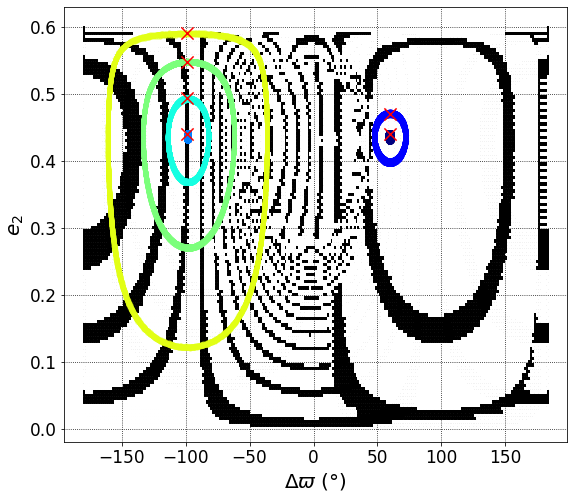

In [10]:
# PROJECTION OF H SURFACE + INTEGRATION
figp = plt.figure(figsize=(9,8))
axp = figp.add_subplot(111, xlabel = r'$\Delta\varpi$ (°)', ylabel = '$e_' + PLA + '$')

# Colors used:
if COLOR:
    colormap = cm.gist_ncar
else:
    colormap = newcm

if (FILTRAR):
    # Data filtering (according box defined in previous cell):
    Din_pro = Din_Hsup[ ~(((E_sup>=emin)&(E_sup<=emax))&((W_sup>=wmin)&(W_sup<=wmax))&((S_sup>=smin)&(S_sup<=smax))) ]
    Din_pro.reset_index(inplace=True)
    # Obtain variables from dataframe:
    E_pro = Din_pro['e' + PLA].values
    W_pro = Din_pro['deltavarpi'].values % 360
    H_pro = -Din_pro['R'].values
    if (ANGLE == 1):
        W_pro = np.where(W_pro>180, W_pro - 360, W_pro)
else:
    E_pro = E_sup
    W_pro = W_sup
    H_pro = H_sup
    
# H surface projection:
plt.scatter(W_pro, E_pro, c = H_pro, marker = 's', s = tam*65, cmap = colormap, zorder = 0, alpha = alfa_H)

# Numerical integration comparison:
if (COMPARAR):
    cmap = plt.cm.get_cmap('jet_r', Nints)
    for i in range(Nints):
        if (PLA == '1'):
            y  = e1int[i]
        else:
            y = e2int[i]
        yi = y[0]
        x  = deltawint[i]
        xi = x[0]
        if PARTICULAR:
            color = 'lime'
        else:
            color = cmap(i)
        # plot:
        if (INT_SHOW[i]):
            plt.scatter(x, y, s = tam_int*30, c = color, marker=".", zorder = 2, alpha = alfa_int)
            plt.scatter(xi, yi, s = tam_int*100, c = 'red', marker="x", zorder = 2) # ics

plt.grid(c='k', ls=':')
# If there are problems of hiding, try changing zorder parameter.

# Save image
if (GUARDAR):
    if (COMPARAR):
        dir_proj = dir_graf
    else:    
        dir_proj = dir_H
    if not os.path.exists(dir_proj):
        os.makedirs(dir_proj)
    file_graf = 'Hproj_ew.' + formato    
    figp.savefig(dir_proj + file_graf, dpi = int(cal), format = formato, bbox_inches='tight');
    print('Saved in: ', dir_proj + file_graf)

Delta_min (in Rhill): 3.00124316
Delta_max (in Rhill): 9.97883323


/tmp/ipykernel_6935/2620164659.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), orientation = 'horizontal', shrink = 1.5)


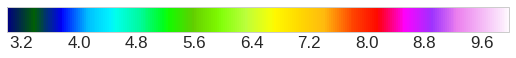

In [20]:
# INTERACTIVE PLOT OF THE 3D mindis SURFACE:
if (MINDIS):
    ipv.style.use('seaborn-darkgrid')
    fig2 = ipv.figure()

    # Colors used:
    colormap2 = cm.gist_ncar
    #colormap2 = cm.flag

    # *** MINDIS: ***
    # Colormap generation:
    min_DIS =  MD_sup.min()
    max_DIS = MD_sup.max()
    znorm2 = MD_sup - min_DIS
    print('Delta_min (in Rhill):', min_DIS)
    print('Delta_max (in Rhill):', max_DIS)
    znorm2 /= znorm2.ptp()
    znorm2.min(), znorm2.max()
    color2 = colormap2(znorm2)

    # * PLOT: *
    ipv.scatter(E_sup, W_sup, S_sup*proy, size=tam, color = color2, marker="sphere")
   
    # Color bar
    norma2 = mpl.colors.Normalize(vmin=min_DIS, vmax=max_DIS)
    cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), orientation = 'horizontal', shrink = 1.5)
    tick_locator = ticker.MaxNLocator(nbins=10)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.gca().set_visible(False)


    # Box limits:
    ipv.xlim(0, np.max(E_sup)*1.01)
    if (ANGLE == 0):
        ipv.ylim(0, 360)
        ipv.zlim(0, 360)
    else:         
        ipv.ylim(-180, 180)
        ipv.zlim(-180, 180)
    # labels   
    ipv.xyzlabel("e"+PLA, "Δϖ", res_angle)

    ipv.show();
    
#  NOTE: Sometimes the interactive plot stop working. Try to re-run this cell. If doesn't work, reboot Jupyter Lab. If not, the pc.

In [12]:
# DATA FILTERING TO LOCATE AN SPECIFIC ACR:

# Locate ACR by looking for max{H}? (if MAX=False it will be looked for min{H})
MAX = False

# Define box limits:
emin = 0.01
emax = 0.9
wmin = -180
wmax = 180
smin = 30
smax = 180

# View angle
elev, azim = 65, 150

ACR located at (e, w, s) = ( 0.44 , -99.0 , 127.0 )
e1 = 0.43173137733165184


/tmp/ipykernel_6935/3684030836.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(),


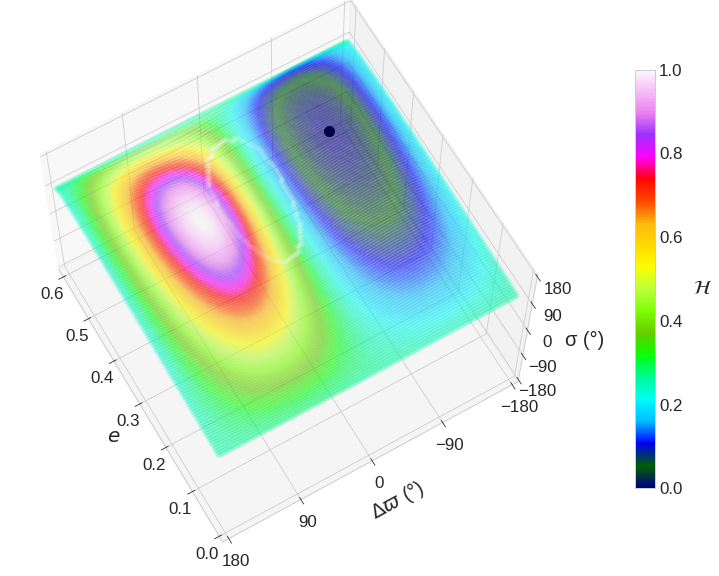

In [13]:
# Data filtering (according box defined in previous cell):
Din_fil = Din_Hsup[ ((E_sup>=emin)&(E_sup<=emax))&((W_sup>=wmin)&(W_sup<=wmax))&((S_sup>=smin)&(S_sup<=smax)) ]
Din_fil.reset_index(inplace=True)

if (MINDIS):    
    Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
    MD_sup = Din_Hsup['mindis'].values

# Obtain variables from dataframe:
E_fil = Din_fil['e' + PLA].values
W_fil = Din_fil['deltavarpi'].values % 360
H_fil = -Din_fil['R'].values
S_fil = Din_fil['sigma1'].values % 360

if (THETA):
    S_fil = (S_fil - (K2-K1)*W_fil) % 360
    
if (ANGLE == 1):
    W_fil = np.where(W_fil>180, W_fil - 360, W_fil)
    S_fil = np.where(S_fil>180, S_fil - 360, S_fil)
    
# Obtengo ACR point asumiendo que se da en el maximo H (mínimo R):
# (si se quisiera buscar en los minimos de H, usar idxmax en lugar de idxmin)
#e_acr = Din_fil[np.max(-Din_fil['R'].values)]
if MAX:
    e_acr = E_fil[Din_fil['R'].idxmin(axis=0, skipna=True)]
    w_acr = W_fil[Din_fil['R'].idxmin(axis=0, skipna=True)]
    s_acr = S_fil[Din_fil['R'].idxmin(axis=0, skipna=True)]
else:
    e_acr = E_fil[Din_fil['R'].idxmax(axis=0, skipna=True)]
    w_acr = W_fil[Din_fil['R'].idxmax(axis=0, skipna=True)]
    s_acr = S_fil[Din_fil['R'].idxmax(axis=0, skipna=True)]    
print('ACR located at (e, w, s) = (',e_acr,',',w_acr,',',s_acr,')')

if (PLA=='1'):
    e2_acr = sqrt( 1 - ( (1+1/eta)*AM_norm - sqrt(1-e_acr**2)/eta )**2 )
    print('e2 =', e2_acr)
else:
    e1_acr = sqrt( 1 - ( (1+eta)*AM_norm - eta*sqrt(1-e_acr**2) )**2 )
    print('e1 =', e1_acr)
    
# PLOT FILTERED DATA:

# Colors used:
colormap = cm.gist_ncar
#colormap = cm.flag
#colormap = newcm
# Colormap generation:
#H_map = np.log10(np.abs(H_sup))
H_map = (H_fil-H_fil.min())/(H_fil.max()-H_fil.min())
min_H = H_map.min()
max_H = H_map.max()
znorm = H_map - min_H
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

# Normal H surface plot:
plt.style.use('seaborn-whitegrid')
fig3 = plt.figure(figsize=(15,10))
ax = fig3.add_subplot(111, projection='3d')

# Scatter plot:
img1 = ax.scatter(E_fil, W_fil, S_fil, c=color, zorder = 0, alpha = 0.1)
ax.scatter(e_acr, w_acr, s_acr, s=100, c='k', zorder = 2)

# Labels y ticks:
ax.set(xlabel = '\n$e$', ylabel = '\n'+r'  $\Delta\varpi$ (°)')
if (ANGLE == 0):
    angles = np.arange(0, 360 + 90, 90)
    ax.set(xlim = [0, np.max(E_sup)*1.01], ylim = [0, 360], zlim = [0, 360], yticks = angles, zticks = angles)
else:
    angles = np.arange(-180, 180 + 90, 90)
    ax.set(xlim = [0, np.max(E_sup)*1.01], ylim = [-180, 180], zlim = [-180, 180], yticks = angles, zticks = angles)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('          ' + res_angle + ' (°)     ', rotation=0)

# Color bar:
norma = mpl.colors.Normalize(vmin=min_H, vmax=max_H)
cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(), 
                   orientation = 'vertical', shrink=0.9, fraction=0.025, pad=0.1)
cb.ax.set_ylabel(r'$\mathcal{H}$', rotation=0, size=20, labelpad = 20) # improvement to do: normalize colorbar...

# View angle:
ax.view_init(elev=elev, azim=azim)

plt.show();

# # Save image
# if (GUARDAR):
#     if not os.path.exists(dir_graf):
#         os.makedirs(dir_graf)
#     fig3.savefig(dir_graf + fileH_graf, dpi = int(cal), format = formato, bbox_inches='tight');
#     print('Saved in: ', dir_graf + fileH_graf)

In [14]:
# Constraints of i.c. search.
# Want ei array from e_acr to grow or decrease?
CRECER = False

# Want to force some values? (comment if not)
# emax = 0.59
emin = 0.6
# e_acr = 0.03
# w_acr = 0
# s_acr = 180

# How many i.c. 3-uples?
cant = 3

In [15]:
# GENERATE DATA FOR NUMERICAL INTEGRATION MOVING FROM THE ACR UP/DOWN IN e

def find_nearest(val, arr):
    amin = arr[0]
    dmin = abs(val-amin)
    for a in arr: 
        if (abs(val-a) < dmin):
            dmin = abs(val-a)
            amin = a
    return amin

print('NUMERICAL INTEGRATION INITIAL CONDITIONS:')
print('')
    
if (PARTICULAR):
    
    if (PLA == '1'):
        e_int = e1i
    else:
        e_int = e2i
    deltawi = w1i - w2i
    w_int = deltawi
    
    Din_S = Din_Hsup[ (W_sup == find_nearest(w_int, w_arr)) & (E_sup == find_nearest(e_int, e_arr)) ]
    S1_int = Din_S['sigma1'].values[0] # It should be only one value!
    
    Nsig = len(Din_S['sigma1'].values)
    if (Nsig>1):
        print('WARNING: There is more than 1 sigma for the particular case!!!') 
        print('sigmas: ',Din_S['sigma1'].values)
        print('Current sigma =', S1_int)
        print('')
    
    if THETA:
        M1_int = (S1_int/K1 - w_int) % 360 
    else:
        M1_int = ((S1_int - K2*w_int)/K1) % 360 
    
    print('a       e        i   longperi  nodo  anomed')
    print(a1i,'   ',e1i,'  0.0  ',w_int,'  0.0   ',M1_int)
    print(a2i,'   ',e2i,'  0.0     0.0     0.0      0.0')
    
    Nint = 1
    
else: # GENERAL CASE:
    
    w_int = w_acr
    if CRECER:
        einf = e_acr
        esup = emax
    else:
        einf = emin
        esup = e_acr        

    # deltae = emax-emin
    # einf = e_acr - 0.2
    # esup = e_acr + 0.2

    # dE = 0.1 # delta e
    # E_int = np.around(np.arange(einf, esup+dE, dE), decimals = 2)
    E_int = np.around(np.linspace(einf, esup, cant) , decimals = 3)
    print('eccentricity array =', E_int)
    print('')

    if (PLA == '1'):
        E1_int = E_int
        E2_int = np.array([])
    else:
        E2_int = E_int
        E1_int = np.array([])

    Nint = len(E_int)
    # initialize
    S1_int = np.array([])
    M1_int = S1_int

    print('a       e                     i  longperi  nodo  anomed')  # EVORB15 header
    for i in range(Nint):
        print('')

        if (PLA == '1'):
            Din_S = Din_fil[ (W_fil == find_nearest(w_int, w_arr)) & (E_fil == find_nearest(E1_int[i], e_arr)) ]
            E2_int = np.append(E2_int, np.sqrt(1 - ((1+1/eta)*AM - (1/eta)*np.sqrt(1-(E1_int[i])**2) )**2) )
        else:
            Din_S = Din_fil[ (W_fil == find_nearest(w_int, w_arr)) & (E_fil == find_nearest(E2_int[i], e_arr)) ]
            E1_int = np.append(E1_int, np.sqrt(1 - ((1+eta)*AM - eta*np.sqrt(1-(E2_int[i])**2) )**2) )
        
        Nsig = len(Din_S['sigma1'].values)
        if (Nsig>0): # Check if it is empty
            
            if THETA:
                ang_res = find_nearest(s_acr, Din_S['sigma1'].values - (K2-K1)*w_int)
                S1_int = np.append(S1_int, ang_res)
                M1_int = np.append(M1_int, (S1_int[i]/K1 - w_int) % 360 )
            else:
                ang_res = find_nearest(s_acr, Din_S['sigma1'].values)
                S1_int = np.append(S1_int, ang_res)
                M1_int = np.append(M1_int, ((S1_int[i] - K2*w_int)/K1) % 360 )
            
            print(a1i,'   ',E1_int[i],'  0.0 ',w_int,'  0.0   ',M1_int[i])
            print(a2i,'   ',E2_int[i],'  0.0     0.0    0.0     0.0')
            print('# sigmas =',Nsig,'; sigma =',S1_int[i])


NUMERICAL INTEGRATION INITIAL CONDITIONS:

eccentricity array = [0.6  0.52 0.44]

a       e                     i  longperi  nodo  anomed

1.0     0.0   0.0  -99.0   0.0    197.0
1.0     0.6   0.0     0.0    0.0     0.0
# sigmas = 1 ; sigma = 98.0

1.0     0.32465140779768326   0.0  -99.0   0.0    223.0
1.0     0.52   0.0     0.0    0.0     0.0
# sigmas = 1 ; sigma = 124.0

1.0     0.43173137733165184   0.0  -99.0   0.0    226.0
1.0     0.44   0.0     0.0    0.0     0.0
# sigmas = 1 ; sigma = 127.0


In [16]:
# Boolean array to select what to integrate:            
INT_FLAG = [True, True, True]      
if ((len(INT_FLAG)!=Nint) and (not PARTICULAR)):
    print('WARNING: Boolean array length did not match number of integrations. Next cell may fail.')
# INTEGRAR = True # Integration flag override

In [17]:
# ***** NUMERICAL INTEGRATIONS *****

if (INTEGRAR):
     
    # Some setup for the integration (the rest of it is below, inside the loop)
 
    # Time setups:
    Ttot  = 1e4    # total int. time
    d_out = 1      # output step
    dT    = 0.001 # paso de la int.
    Nout  = int(Ttot/d_out) # puntos en la salida

    # Conversion factors:
    G2R = pi/180
    R2G = 180/pi

    # Fixed elements:
    w2i = 0 # fixed
    M2i = 0 # fixed
    w1i = w_int
    
    # File names:
    file_plot1 = "planet1." + formato 
    file_plot2 = "planet2." + formato 
    file_plot3 = "others." + formato 
    file_data1 = "planet1.dat"  
    file_data2 = "planet2.dat"  
        
    # Progress bar indicator:
    print('Progress:')
    barra = IntProgress(min=0, max=Nout*Nint) # instantiate the bar
    display(barra) # display the bar
    
    # data format and headers
    formato_data = "%6.2f %8.6f %8.6f %5.2f %5.2f"
    nom_cols1 = "    t    a1       e1      w1  lambda1"
    nom_cols2 = "    t    a2       e2      w2  lambda2"
    
    # LOOP 
    for i in range(Nint):

        if (INT_FLAG[i] or PARTICULAR):
            # Simulation creation
            sim = rebound.Simulation()

            # Integration algorithm:
            # sim.integrator = "whfast"
            sim.integrator = "mercurius" 
            #sim.ri_mercurius.hillfac = 4. # Hill radius for mercurius
            sim.ri_mercurius.hillfac = RHtol

            # Reference system:
            # sim.ri_whfast.coordinates = 'jacobi' #default
            # sim.ri_whfast.coordinates = 'democraticheliocentric' # ~ Poincare
            # sim.ri_whfast.coordinates = 'whds'
            sim.ri_mercurius.coordinates = 'democraticheliocentric'

            # Units:
            sim.units = ('yrs', 'AU', 'Msun')   
            #sim.t = Ttot
            sim.dt = dT

            # Improve performance & accuaracy:
            # sim.ri_whfast.safe_mode = 0
            # sim.ri_whfast.corrector = 11 # Solo en Jacobi

            KG2 = sqrt(sim.G)
            #print(KG2)

            if PARTICULAR:
                # e1i and e2i are already assigned
                M1i = M1_int
                s1i = S1_int
            else:
                e1i = E1_int[i]
                e2i = E2_int[i]
                M1i = M1_int[i]
                s1i = S1_int[i]

            # (last) folder (in path) to save the integration data:
            if (PLA == '1'):
                if THETA:
                    caso_int = "e1=%.2f_dw=%d_s2=%d" % (e1i, int(w1i), int(s1i))
                else:
                    caso_int = "e1=%.2f_dw=%d_s1=%d" % (e1i, int(w1i), int(s1i))
            else:
                if THETA:
                    caso_int = "e2=%.2f_dw=%d_s2=%d" % (e2i, int(w1i), int(s1i))
                else:
                    caso_int = "e2=%.2f_dw=%d_s1=%d" % (e2i, int(w1i), int(s1i))

            # DOBJECTS DEFINITION:
            star = sim.add(m=m0)            
            pla1 = sim.add(m=m1, a=a1i, e=e1i, inc=0*G2R, pomega=w1i*G2R, Omega=0*G2R, M=M1i*G2R)
            pla2 = sim.add(m=m2, a=a2i, e=e2i, inc=0*G2R, pomega=w2i*G2R, Omega=0*G2R, M=M2i*G2R)

            particles = sim.particles

            #sim.status()

            # Variable initiallization:
            times = np.linspace(0, Ttot, Nout)
            t1 = times
            t2 = times
            a1 = np.zeros(Nout)
            e1 = np.zeros(Nout)
            w1 = np.zeros(Nout)
            l1 = np.zeros(Nout)
            a2 = np.zeros(Nout)
            e2 = np.zeros(Nout)
            w2 = np.zeros(Nout)
            l2 = np.zeros(Nout)

            # *** INTEGRATION STARTS ***
            # Integrate in steps (Ttot/Nout) y save the elements:
            for i,time in enumerate(times):
                sim.integrate(time, exact_finish_time=0)
                a1[i] = particles[1].a
                e1[i] = particles[1].e
                w1[i] = (particles[1].pomega)*R2G % 360
                l1[i] = (particles[1].l)*R2G % 360
                a2[i] = particles[2].a
                e2[i] = particles[2].e
                w2[i] = (particles[2].pomega)*R2G % 360
                l2[i] = (particles[2].l)*R2G % 360
                barra.value += 1 # signal to increment the progress bar

            #sim.status()

            # Other important quantitites:
            deltaW = (w1-w2) % 360
            theta = (K1*l1-K2*l2) % 360
            s1 = (theta + (K2-K1)*w1) % 360
            s2 = (theta + (K2-K1)*w2) % 360
            ds = (theta + (K2-K1)*deltaW) % 360

            # Angles shifting:
            w1 = w1 % 360
            w2 = w2 % 360
            l1 = l1 % 360
            l2 = l2 % 360
            if (ANGLE == 1):
                w1 = np.where(w1>180, w1 - 360, w1)
                l1 = np.where(l1>180, l1 - 360, l1)
                s1 = np.where(s1>180, s1 - 360, s1)
                w2 = np.where(w2>180, w2 - 360, w2)
                l2 = np.where(l2>180, l2 - 360, l2)
                s2 = np.where(s2>180, s2 - 360, s2)
                deltaW = np.where(deltaW>180, deltaW - 360, deltaW)
                theta = np.where(theta>180, theta - 360, theta)
                ds = np.where(ds>180, ds - 360, ds)
                angle_yticks = np.arange(-180,270,90)
            else:
                angle_yticks = np.arange(0,450,90)

            # *** INTEGRATION ENDS ***

            # Calculate mean a1 to correct a1i (structure law)
            #print(a1.mean())


            # *** START PLOTS ***


            # PLANET 1 PLOTS
            fig, axs = plt.subplots(4, 1, figsize = (16, 9), sharex = 'col', sharey = False)

            # Gráficos: a(t), e(t) y ángulos(t).
            axs[0].plot(t1, a1, 's', marker = '.', ms = 1, c='k')
            axs[1].plot(t1, e1, 's', marker = '.', ms = 1, c='k')
            axs[2].plot(t1, w1, 's', marker = '.', ms = 1, c='k')
            axs[3].plot(t1, s1, 's', marker = '.', ms = 1, c='k')

            # Labels y ticks:
            axs[0].set(ylabel = '$a_1$ (au)', ylim = [0.9995*min(a1), 1.0005*max(a1)])
            axs[1].set(ylabel = '$e_1$', ylim = [0, 1], yticks = [0, 0.5 ,1])
            axs[2].set(ylabel = r'$\varpi_1$ (°)', yticks = angle_yticks)
            axs[3].set(ylabel = r'$\sigma_1$ (°)', xlabel = 't (years)', yticks = angle_yticks);

            if GUARDAR:
                dir_plot = dir_H + int_setup + caso_int + "/"
                if not os.path.exists(dir_plot):
                    os.makedirs(dir_plot)
                plt.savefig(dir_plot + file_plot1, bbox_inches = 'tight', dpi = int(cal), format = formato);  
                print('Saved in:', dir_plot + file_plot1)

            plt.show();

            # PLANET 2 PLOTS
            fig, axs = plt.subplots(4, 1, figsize = (16, 9), sharex = 'col', sharey = False)

            # Gráficos: a(t), e(t) y ángulos(t).
            axs[0].plot(t2, a2, 's', marker = '.', ms = 1, c='k')
            axs[1].plot(t2, e2, 's', marker = '.', ms = 1, c='k')
            axs[2].plot(t2, w2, 's', marker = '.', ms = 1, c='k')
            axs[3].plot(t2, s2, 's', marker = '.', ms = 1, c='k')

            # Labels y ticks:
            axs[0].set(ylabel = '$a_2$ (au)', ylim = [0.9995*min(a2), 1.0005*max(a2)])
            axs[1].set(ylabel = '$e_2$', ylim = [0, 1], yticks = [0, 0.5 ,1])
            axs[2].set(ylabel = r'$\varpi_2$ (°)', yticks = angle_yticks)
            axs[3].set(ylabel = r'$\sigma_2$ (°)', xlabel = 't (years)', yticks = angle_yticks);

            if GUARDAR:
                plt.savefig(dir_plot + file_plot2, bbox_inches = 'tight', dpi = int(cal), format = formato);  
                print('Saved in:', dir_plot + file_plot2)

            plt.show();


            # OTHER PLOTS
            fig, axs = plt.subplots(3, 1, figsize = (16, 7), sharex = 'col', sharey = False)

            # Gráficos: a(t), e(t) y ángulos(t).
            axs[0].plot(t1, deltaW, 's', marker = '.', ms = 1, c='k')
            axs[1].plot(t1, theta, 's', marker = '.', ms = 1, c='k')
            axs[2].plot(t1, ds, 's', marker = '.', ms = 1, c='k')

            # Labels y ticks:
            axs[0].set(ylabel = r'$\Delta\varpi$ (°)', yticks = angle_yticks)
            axs[1].set(ylabel = r'$\theta$ (°)', yticks = angle_yticks)
            axs[2].set(ylabel = r'$\sigma^*$ (°)', xlabel = 't (years)', yticks = angle_yticks);

            if GUARDAR:
                plt.savefig(dir_plot + file_plot3, bbox_inches = 'tight', dpi = int(cal), format = formato);  
                print('Saved in:', dir_plot + file_plot3)

            plt.show();

            # SAVE NUM INT DATA
            if GUARDAR:
                dir_data = dir_plot
                data1 = np.c_[t1, a1, e1, w1, l1]
                data2 = np.c_[t2, a2, e2, w2, l2]
                np.savetxt(dir_data + file_data1, data1, fmt=formato_data, header = nom_cols1, comments='')
                np.savetxt(dir_data + file_data2, data2, fmt=formato_data, header = nom_cols2, comments='')
                print('Saved in:', dir_data)

            # Just in case:
            del sim.particles
            sim = None # free the memory

print('All cells were ejecuted successfully! :)')

All cells were ejecuted successfully! :)


In [18]:
# PROGRAM END